# Multiclass Classification

- importing data and train test spit is the same as a binary classifier

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Importing the MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

X, y = mnist['data'], mnist['target']

In [4]:
y = y.astype(np.uint8) # Convert labels to integers

In [5]:
# Train Test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000:], y[60000:]

## Using a binary classifier for multiclass classification

- Sckit-learn detect when you are trying to use a binary classifier for a multiclass classification and uses OvA, (one vs all).
- One vs all is a methord where a binary classifier is run against all combinations of classification and the one that wins the most is the correct one. Ex classify 1 & not 1, ...
- OvA is not alavaible for SVM for them we use OvO, (one vs one). Example 1 or 2, ... , 2 or 3

In [6]:
# Import a linear model
from sklearn.linear_model import SGDClassifier

In [7]:
sdgc = SGDClassifier(random_state = 1)
sdgc.fit(X_train,y_train) #This time we are not using y_train_5

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

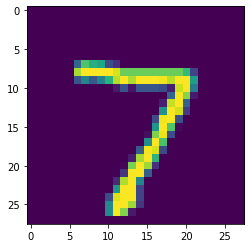

In [11]:
plt.imshow(X_test[0].reshape(28, 28))
random_example = X_test[0]

In [12]:
sdgc.predict([random_example]) # Note that the input must be an array

array([7], dtype=uint8)

- Under the hood sklearn actually created 10 binary classifier, recall OvA.
- Got their decision scores for the images and picket the number with the highest decision score

### You can view the decision score using the decision_function methord

In [14]:
decision_score = sdgc.decision_function([random_example])
decision_score

array([[-40873.51954136, -41815.47272802, -13272.15173223,
         -3511.12720926, -19769.39170358, -10616.33654371,
        -28674.90243604,   7462.06708468,  -8897.55340689,
         -4659.53230991]])

In [16]:
np.argmax(decision_score) # The highest score is in the 7th position

7

- You can force sklean to use one vs one classifiers

In [17]:
from sklearn.multiclass import OneVsOneClassifier

# Creating OvO classifier for the SGDClassifier which is OvA
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=1))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([random_example])

array([7], dtype=uint8)

- But since we are using we are going to have a lot more binary classifiers.
- The number of classifiers are going to follow the following formula

\begin{equation*}
\frac {N \times (N-1)}{2}
\end{equation*}

- So we are going to have 45 classifiers in this case (10 * 9)/2

In [18]:
len(ovo_clf.estimators_)

45

## Training a RandomForestClassifier

- for this classifier sklearn does not need to use OvO or OvA because random forest Classifier is already a multiclass classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.predict([random_example])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([7], dtype=uint8)

In [21]:
# View the probabilities of each class

forest_clf.predict_proba([random_example])

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

## Cross Validation

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
cross_val_score(sdgc, X_train, y_train, cv = 3, scoring='accuracy')

array([0.87607479, 0.86274314, 0.85242786])

- The model performs fine but we can make the model a lot more accurate.
- For instance we could make the model more accurate just by scaling the data

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sdgc, X_train_scaled, y_train, cv = 3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89977005, 0.89429471, 0.90408561])

## Error Analysis

- Confusion Matrix

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [27]:
y_train_pred = cross_val_predict(sdgc, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5588,    0,   21,    6,    8,   46,   39,    6,  208,    1],
       [   1, 6402,   37,   25,    4,   45,    4,    8,  203,   13],
       [  28,   26, 5237,   94,   73,   27,   67,   38,  357,   11],
       [  23,   17,  118, 5237,    2,  213,   27,   40,  381,   73],
       [  12,   14,   46,   10, 5197,   12,   37,   27,  311,  176],
       [  28,   15,   30,  172,   53, 4466,   77,   15,  501,   64],
       [  30,   15,   43,    2,   44,   99, 5556,    5,  123,    1],
       [  20,   10,   52,   29,   48,   12,    3, 5703,  165,  223],
       [  19,   63,   45,   84,    3,  127,   25,   11, 5427,   47],
       [  21,   18,   30,   63,  119,   37,    1,  180,  330, 5150]])

- As you can see that those are a lot of numbers
- It is many times useful to turn the matrix into a visual as shown below

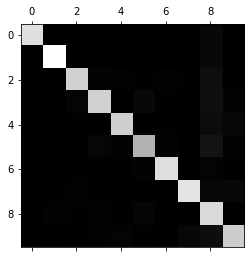

In [29]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- This diagram looks good, the light diagnol shows that most of the result were accurately matched to their target

## Multilabel Classification

- If you want to label multiple things at the same time
- For instance think of a face-recognition classifier, it should be able recognize multiple people at the same time. So for example if Alice and Bob are in the same picture it should be able to recognize both of them

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
y_train_large = (y_train > 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel # label for each number, displaying weather the number is odd or even and small or large --> [[0,1]]

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [31]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
knn_clf.predict([random_example]) # 7 is small and odd and indeed it got it right

array([[False,  True]])

## Multioutput Classification
- It is generalization of multilabel classification
- It can be classified as more than just 1 thing.ie 1 and 2

- To illustrate this lets create a system removes noise from images
- It will take input a noisy digit image and it will output a clean digit image
- Note how the the output is more than just 1, there is a output for each noisy input pixel

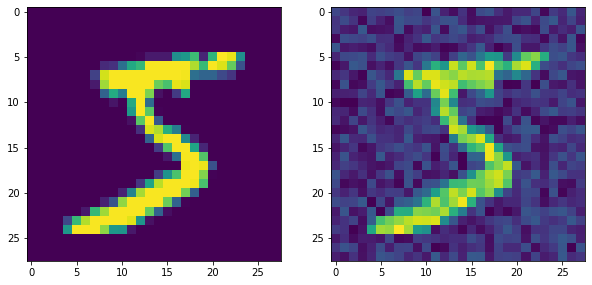

In [54]:
# Creating noise
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train+noise
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(X_train[0].reshape(28, 28))
fig.add_subplot(1, 2, 2)
plt.imshow(X_train_mod[0].reshape(28, 28))
plt.show()

In [57]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test+noise

In [55]:
# Adding the targets
y_train_mod = X_train
y_test_mod = X_test

In [59]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

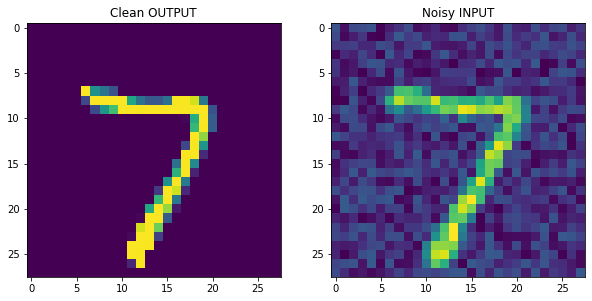

In [63]:
clean_digit = knn_clf.predict([X_test_mod[0]])
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.title('Clean OUTPUT')
plt.imshow(clean_digit.reshape(28, 28))
fig.add_subplot(1, 2, 2)
plt.title('Noisy INPUT')
plt.imshow(X_test_mod[0].reshape(28, 28))
plt.show()